In [19]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
import datetime as dt
import pandas as pd
import os
from numpy import inf
from sklearn.metrics import mean_squared_error

In [2]:
n = 2**10
t = 10**4
p = 0.0154
omega = 1
size = 1
k = 1

In [3]:
def buy_sell_hold(p):
    assert p <= 0.5, "p should be smaller than 0.5"
    p_b = p # buy/sell
    p_s = p
    p_h = 1 - 2*p # hold
    dice = rnd.uniform(0, 1)
    # if the dice rolls below p, roll a 50/50 dice to decide buy or sell
    if dice <= 2*p:
        if rnd.choice([0, 1]) == 0:
            psi = 1
        else:
            psi = -1
    else:
        psi = 0
    return psi

In [4]:
class Agent:
    def __init__(self, size) -> None:
        self.size = size

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:
        if sum(self.daily_return) != 0:
            c = (self.n // abs(sum(self.daily_return))) ** self.omega
        else:
            c = self.n
            
        opinion_groups = [[] for i in range(c)]
        opinion_agents = self.agents.copy()

        for opinion_group in opinion_groups:
            for i in range(round(self.n / c)):
                if len(opinion_agents) > 0:
                    i = rnd.choice([i for i in range(len(opinion_agents))])

                    opinion_group.append(opinion_agents[i])
                    del opinion_agents[i]
                else:
                    break
                
        return opinion_groups

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

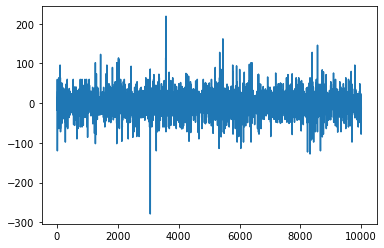

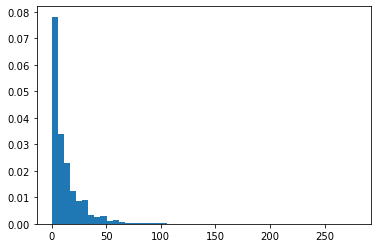

In [9]:
# ABM

model_test = Model(p, n, size, k, omega)
for i in range(t):
    model_test.step()

plt.plot(range(t), model_test.daily_returns)
plt.show()

# find a way to log-log
returns = [abs(day) for day in model_test.daily_returns]
plt.hist(returns, 50, density=True)
plt.show()

In [6]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []
        
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [7]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

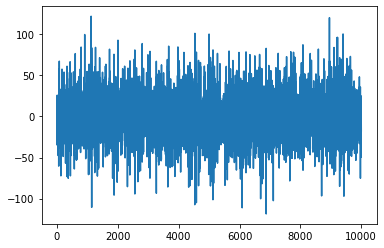

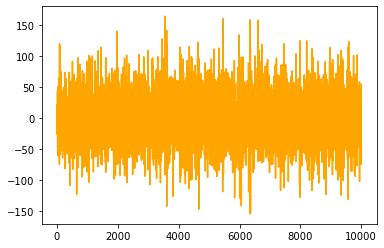

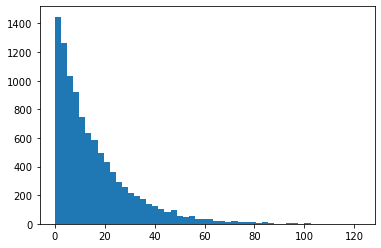

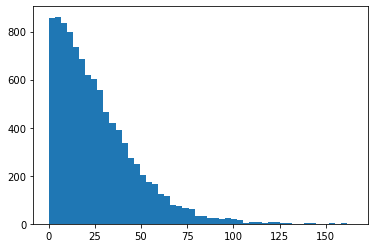

In [8]:
plt.plot(range(t + 1), stochastic.returns)
plt.show()

plt.plot(range(t+1), stochastic_horizons.returns, color='orange')
plt.show()

abs_returns = [abs(i) for i in stochastic.returns]
abs_returns_horizons = [abs(i) for i in stochastic_horizons.returns]
plt.hist(abs_returns, 50)
plt.show()
plt.hist(abs_returns_horizons, 50)
plt.show()

### Grid Search

In [12]:
# importing data
df_clean_daily_returns = pd.read_csv('data/df_clean_daily_returns.csv')
df_volume_clean = pd.read_csv('data/df_volume_clean.csv')


In [13]:
# plottings daily return distribution

# removing date time index and date column
df_clean_daily_returns.reset_index(drop=True, inplace=True)
df_clean_daily_returns.drop(columns=['Date'], inplace=True)
# flattening the 2D dataframe into 1D array
flattened_returns = df_clean_daily_returns.to_numpy().flatten()
print(flattened_returns)
abs_returns = abs(flattened_returns)

[ 0.00358163 -0.0228898   0.         ... -0.00258157 -0.00434899
  0.00162995]


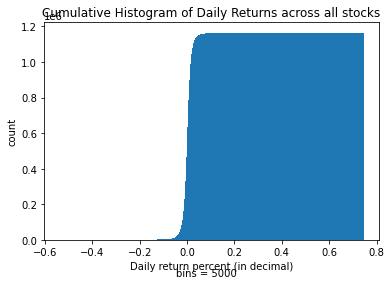

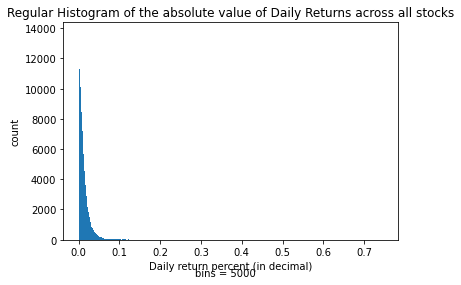

In [15]:
# # Plotting cumulative histogram of daily returns across all stocks by 
# bins = 5000
# plt.hist(flattened_returns, bins, cumulative = True)
# plt.title('Cumulative Histogram of Daily Returns across all stocks')
# plt.xlabel('Daily return percent (in decimal)')
# plt.ylabel('count')
# plt.figtext(0.5, 0.01, f'bins = {bins}', ha='center', va='center')
# plt.show()
# Plotting regular histogram of daily returns across all stocks by 
bins = 5000
plt.hist(abs_returns, bins)
plt.title('Regular Histogram of the absolute value of Daily Returns across all stocks')
plt.xlabel('Daily return percent (in decimal)')
plt.ylabel('count')
plt.figtext(0.5, 0.01, f'bins = {bins}', ha='center', va='center')
plt.show()

Real world data is in %. Change real world and test to the same.
Try different parameters to see what the rmse gives.

In [21]:
rmse = np.sqrt(mean_squared_error(real, result))

NameError: name 'real' is not defined